In [1]:
import os
import sys
sys.path.insert(0, "..")
os.chdir("..")

In [2]:
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.nn.functional as F
%matplotlib inline

sys_rand = random.SystemRandom()

/anaconda/envs/fcn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [61]:
from torch import nn
import timm


class FCN32(nn.Module):
    def __init__(
        self,
        backbone_name,
        pretrained_backbone,
        n_classes,
    ):
        super().__init__()

        # Create only feature extractor from timm models.
        self.backbone = timm.create_model(
            backbone_name, pretrained=pretrained_backbone, num_classes=0, global_pool=""
        )

        # Find first conv and add paddings (100, 100) to be able
        # to upsample features to the initial size.
        for module in self.backbone.modules():
            if isinstance(module, nn.Conv2d) and module.in_channels == 3:
                module.padding = (100, 100)
        
        self.score_fr = nn.Conv2d(
            in_channels=self.backbone.num_features,
            out_channels=n_classes,
            kernel_size=(1, 1),
        )
        self.upscore = nn.ConvTranspose2d(
            in_channels=n_classes,
            out_channels=n_classes,
            kernel_size=64,
            stride=32,
            bias=False,
        )
    def forward(self, x):
        *_, h, w = x.shape
        x = self.score_fr(self.backbone(x))
        return self.upscore(x)[:, :, 19: 19 + h, 19: 19 + w]

In [1]:
from torchvision.models import vgg16, VGG16_Weights

/anaconda/envs/fcn/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
import torch


class F(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = vgg16(weights=VGG16_Weights.DEFAULT)
        self.vgg16.features[0].padding = (100, 100)
        weights = self.classifier[0].weight.data

In [12]:
F()

F(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): Ma

In [57]:
timm.list_models("*regnet*")

['haloregnetz_b',
 'nf_regnet_b0',
 'nf_regnet_b1',
 'nf_regnet_b2',
 'nf_regnet_b3',
 'nf_regnet_b4',
 'nf_regnet_b5',
 'regnetv_040',
 'regnetv_064',
 'regnetx_002',
 'regnetx_004',
 'regnetx_006',
 'regnetx_008',
 'regnetx_016',
 'regnetx_032',
 'regnetx_040',
 'regnetx_064',
 'regnetx_080',
 'regnetx_120',
 'regnetx_160',
 'regnetx_320',
 'regnety_002',
 'regnety_004',
 'regnety_006',
 'regnety_008',
 'regnety_016',
 'regnety_032',
 'regnety_040',
 'regnety_040s_gn',
 'regnety_064',
 'regnety_080',
 'regnety_120',
 'regnety_160',
 'regnety_320',
 'regnetz_005',
 'regnetz_040',
 'regnetz_040h',
 'regnetz_b16',
 'regnetz_b16_evos',
 'regnetz_c16',
 'regnetz_c16_evos',
 'regnetz_d8',
 'regnetz_d8_evos',
 'regnetz_d32',
 'regnetz_e8']

In [3]:
from source.utils.general import read_config
from source.datasets.voc import VOC_COLORMAP

config = read_config("config.yml")

In [10]:
from source.datasets.utils import read_image, read_mask_voc

In [5]:
import os.path as osp
from PIL import Image

data_path = osp.join("data", "VOCdevkit", "VOC2012")
set_path = "data/VOCdevkit/VOC2012/ImageSets/Segmentation/seg11valid.txt"
with open(set_path, "r") as tfs:
    names = [img.replace("\n", "") for img in tfs.readlines() if img != "\n"]
images = []
labels = []
for name in names:
    images.append(osp.join(data_path, "JPEGImages", name + ".jpg"))
    labels.append(osp.join(data_path, "SegmentationClass", name + ".png"))

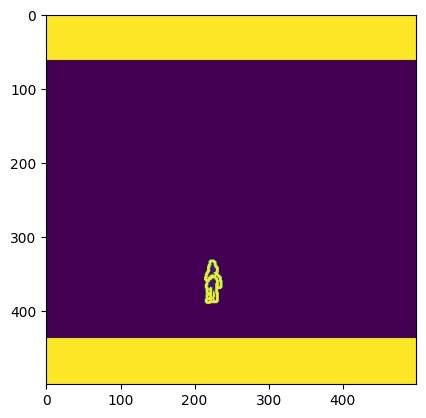

In [11]:
plt.imshow(read_mask_voc(labels[120]))

In [14]:
from source.models import FCN32VGG16
from source.utils.augmentations import get_albumentation_augs

transforms = get_albumentation_augs(config)["val"]
model = FCN32VGG16(config).to("cpu")
model.load_state_dict(torch.load("logs/2023-02-26 06:44:23.753710/weights/fcn_iou_0.5540962815284729.pt"))
model.eval();

FCN32VGG16(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(100, 100))
  (relu1_1): ReLU(inplace=True)
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1_2): ReLU(inplace=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_1): ReLU(inplace=True)
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2_2): ReLU(inplace=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_1): ReLU(inplace=True)
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_2): ReLU(inplace=True)
  (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu3_3): ReLU(inplace=True)
  (pool3): MaxPool2d(kernel_s

In [15]:
fixed_batch =  (
    torch.randn(10, 3, 333, 516) * torch.as_tensor([255, 0, 0]).view(1, -1, 1, 1)
    ).clamp(0, 255)
outputs =  (
    torch.randn(10, 3, 333, 516) * torch.as_tensor([0, 255, 0]).view(1, -1, 1, 1)
    ).clamp(0, 255)
masks = (
    torch.randn(10, 3, 333, 516) * torch.as_tensor([0, 0, 255]).view(1, -1, 1, 1)
).clamp(0, 255)

In [51]:
log_batch = torch.zeros(3 * 10, 3, 333, 516)
for i in range(10):
    log_batch[3 * i, :, :, :] = fixed_batch[i]
    log_batch[3 * i + 1, :, :, :] = masks[i]
    log_batch[3 * i + 2, :, :, :] = outputs[i]

In [53]:
from torchvision.utils import make_grid, save_image

grid = make_grid(log_batch, nrow=outputs.shape[0] // 3)
save_image(grid, "t.png")

In [54]:
IMAGENET_MEAN = torch.as_tensor([0.485, 0.456, 0.406])
IMAGENET_STD = torch.as_tensor([0.229, 0.224, 0.225])

In [32]:
@torch.inference_mode()
def t(model, fixed_batch, device):
    model.eval()
    images, labels = fixed_batch
    batch_size, _, height, width = images.shape
    outputs = model(images.to(device=device, non_blocking=True))
    outputs = outputs.argmax(dim=1).squeeze(dim=0).detach().cpu()
    out = torch.zeros((*outputs.shape, 3))
    for i in range(out.shape[0]):
        for j in range(len(VOC_COLORMAP)):
            out[i, outputs[i] == j] = torch.as_tensor(VOC_COLORMAP[j], dtype=torch.float)
    log_batch = torch.zeros((3 * batch_size, 3, height, width))
    for i in range(batch_size):
        log_batch[3 * i, :, :, :] = images[i]
        log_batch[3 * i + 1, :, :, :] = labels[i]
        log_batch[3 * i + 2, :, :, :] = out[i]
    grid = make_grid(log_batch, nrow=batch_size // 3)
    save_image(grid, "t.png")
    

In [33]:
t(model, (torch.randn(5, 3, 333, 516), torch.randn(5, 1, 333, 516)), torch.device("cpu"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


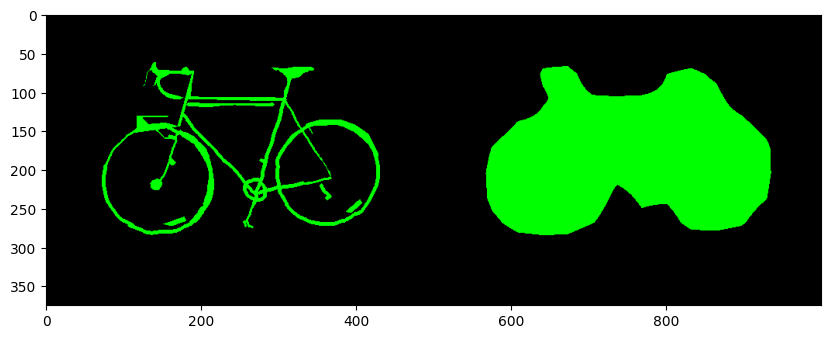

In [31]:
def read_sample(image_path, mask_path):
    image = np.array(Image.open(image_path).convert("RGB"))
    label = np.array(Image.open(mask_path)).astype(np.int32)
    label2 = np.zeros((*label.shape, 3))
    for i in range(len(VOC_COLORMAP)):
        label2[label == i] = VOC_COLORMAP[i]
    return image, label, label2


image, label, label2 = read_sample(images[512], labels[512])
tensor = transforms(image=image)["image"].unsqueeze(dim=0)
with torch.no_grad():
    outputs = model(tensor)
    outputs = outputs.argmax(dim=1).squeeze(dim=0).detach().cpu().numpy()
    out = np.zeros((*outputs.shape, 3))
    for i in range(len(VOC_COLORMAP)):
        out[outputs == i] = VOC_COLORMAP[i]
to_show = np.hstack((label2, out))
plt.figure(figsize=(10, 6))
plt.imshow(to_show)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


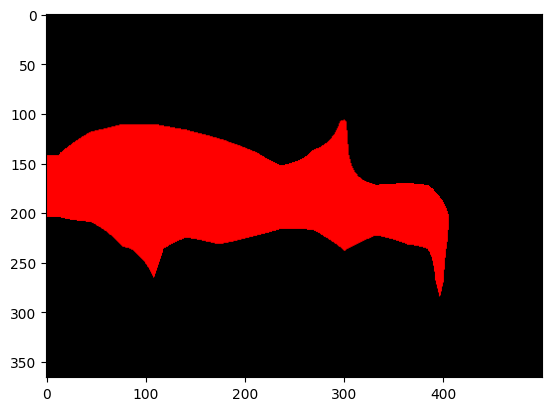

In [24]:
plt.imshow(out)

In [33]:
import torch
from source.datasets.utils import VOC_CLASSES


IMAGENET_MEANS = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

print(len(VOC_CLASSES))


def show_image(image: np.ndarray) -> None:
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def show_image_with_masks(image, mask) -> None:
    if isinstance(image, torch.Tensor):
        image = image.numpy().transpose(1, 2, 0)
        image = ((image * IMAGENET_STD + IMAGENET_MEANS) * 255).astype(np.uint8)
    if isinstance(mask, torch.Tensor):
        print(torch.unique(mask * 255))
        mask = mask.numpy().transpose(1, 2, 0)
        mask = (255 * mask).astype(np.uint8)
    _, axs = plt.subplots(nrows=2, ncols=11, figsize=(16, 4))
    axs[0, 0].imshow(image)
    axs[0, 0].axis("off")
    axs[0, 0].set_title("Source image")
    t = VOC_CLASSES[1:]
    for i in range(1, len(t) + 1):
        row = i // 11
        col = i % 11
        axs[row, col].imshow(mask[:, :, i-1], cmap="gray")
        axs[row, col].axis("off")
        axs[row, col].set_title(t[i-1])
    plt.tight_layout()
    plt.show()

21


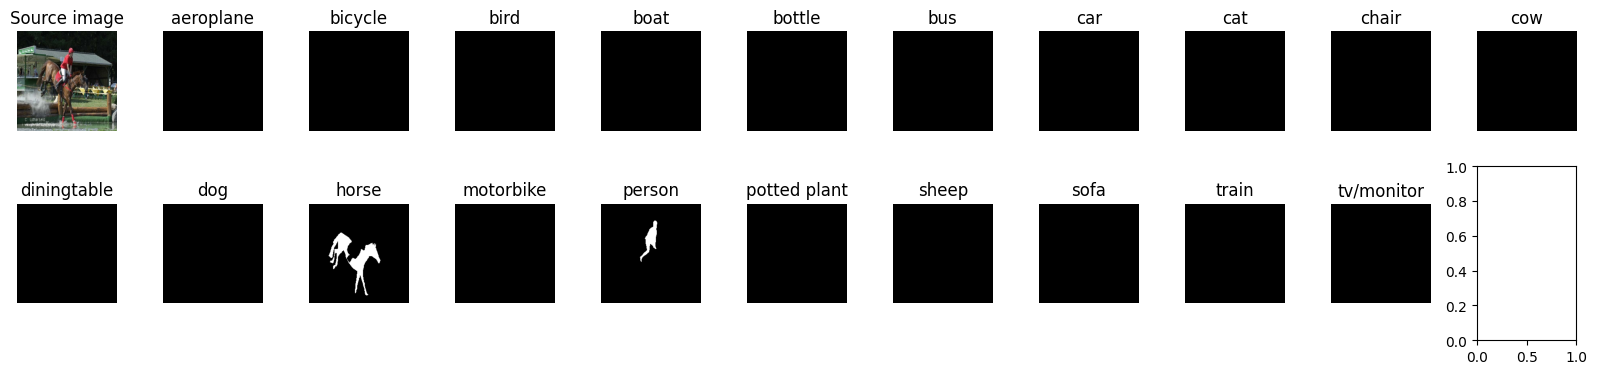

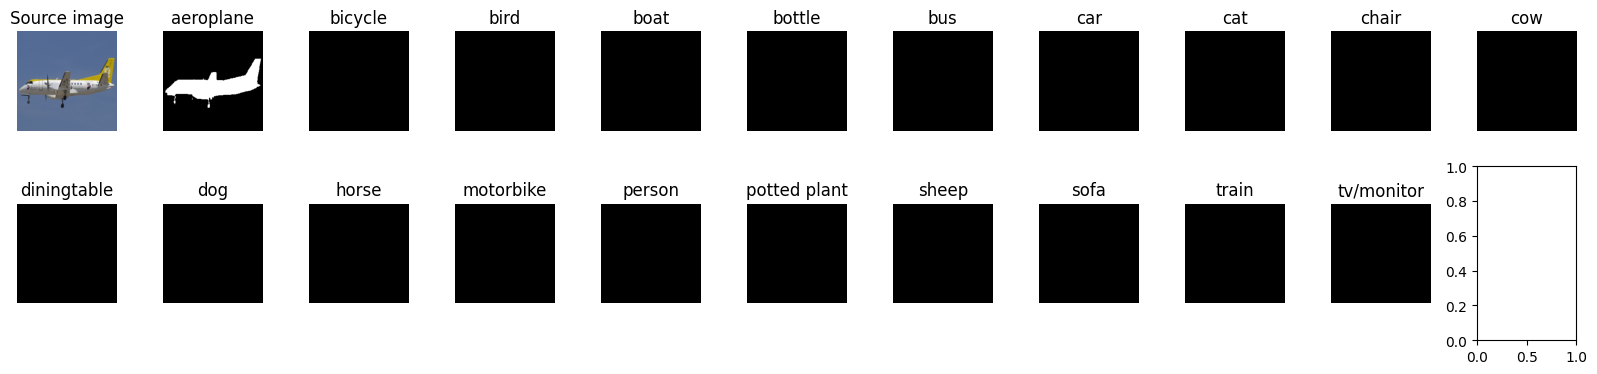

In [13]:
from source.utils.general import read_config
from source.datasets import VOCSegmentation


config = read_config("config.yml")
dataset = VOCSegmentation(config, "train", None)
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

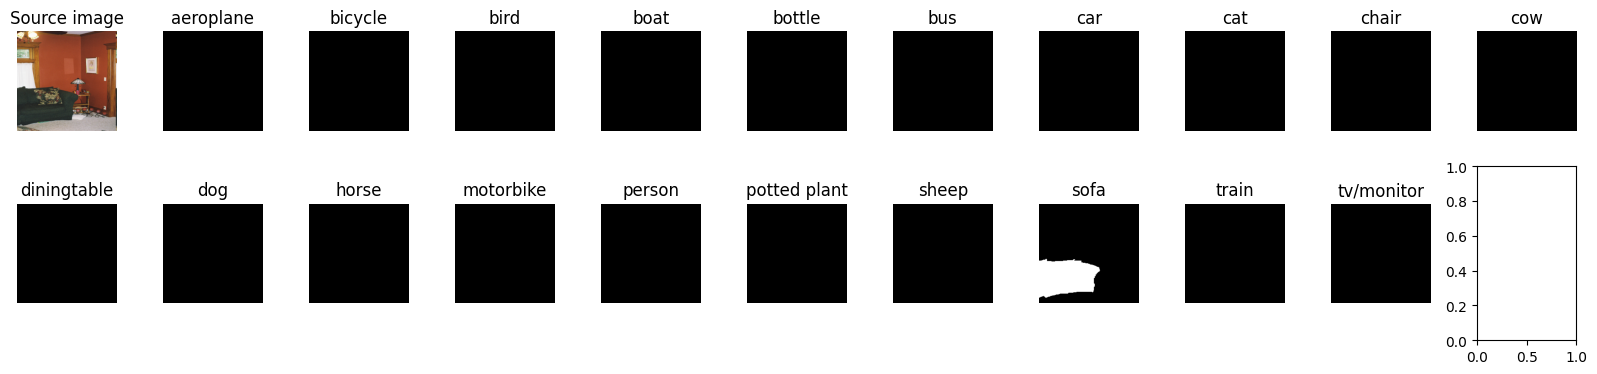

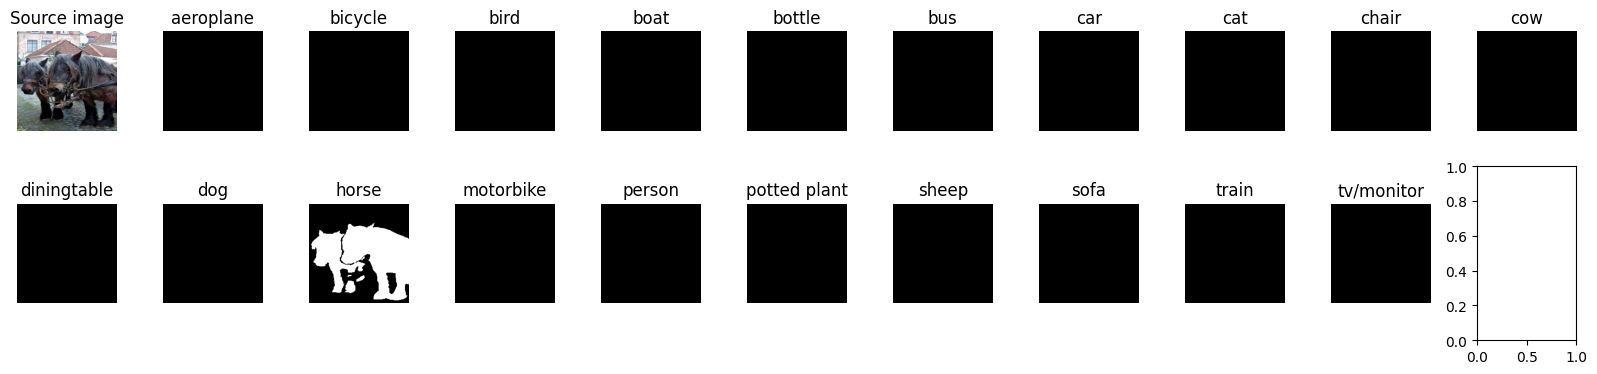

In [14]:
dataset = VOCSegmentation(config, "val", None)
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

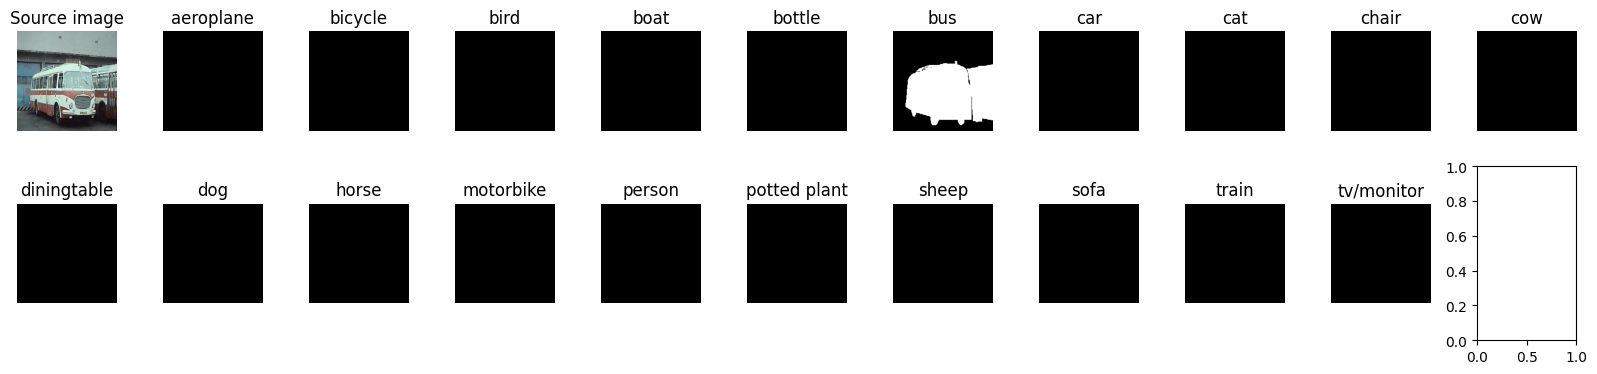

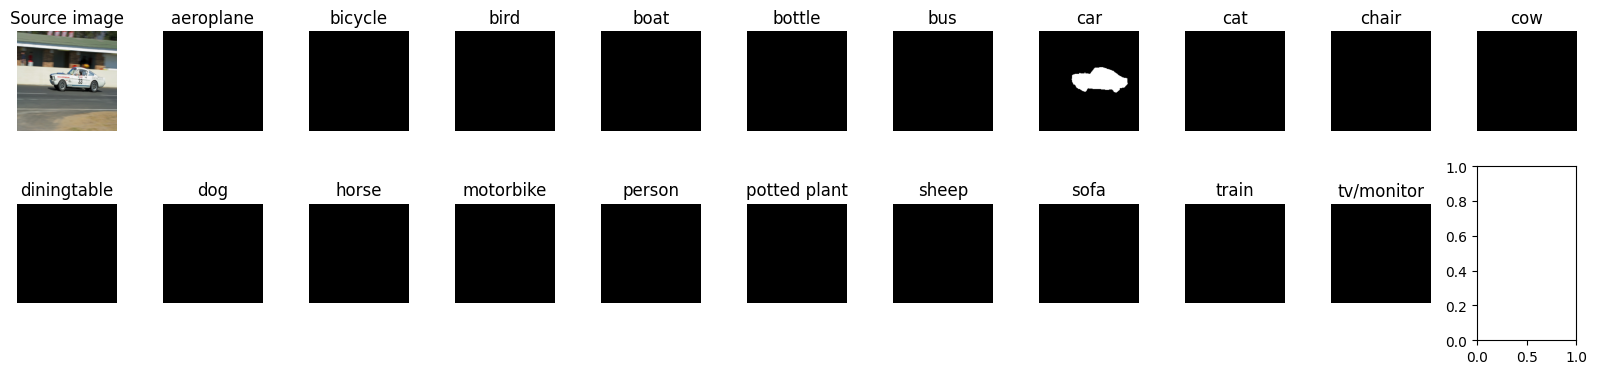

In [15]:
from source.utils.augmentations import get_albumentation_augs


dataset = VOCSegmentation(config, "train", get_albumentation_augs(config)["train"])
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

In [55]:
dataset = VOCSegmentation(config, "val", get_albumentation_augs(config)["val"])
random_indices = [sys_rand.choice(range(len(dataset))) for _ in range(2)]
for idx in random_indices:
    image, mask = dataset[idx]
    show_image_with_masks(image, mask)

tensor([0., 1.])
tensor([0., 1.])


In [51]:
from source.models import FCN32VGG16

model = FCN32VGG16(config)
model.load_state_dict(torch.load("logs/2023-02-22 11:24:05.879670/weights/fcn_2023-02-22 14:08:13.586987_0.06725.pt"))

<All keys matched successfully>

In [52]:
device = torch.device("cpu")
model = model.to(device)
model.eval();

In [ ]:
dataset = VOCSegmentation(config, "val", get_albumentation_augs(config)["val"])
random_indices = range(200)
for idx in random_indices:
    image, masks = dataset[idx]
    to_infer = image.unsqueeze(dim=0).to(device)
    outputs = model(to_infer)
    outputs = (outputs.squeeze(dim=0).detach().cpu().sigmoid() >= 0.06).to(torch.float)
    show_image_with_masks(image, outputs)

In [61]:
from torchvision.models import alexnet, AlexNet_Weights

In [62]:
anet = alexnet(weights=AlexNet_Weights.DEFAULT);

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /home/azureuser/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100.0%


In [63]:
anet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 